<a href="https://colab.research.google.com/github/LuanMagioli/LAIS-23-2022/blob/main/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This study uses a dataset of about 3,700 photos of depth indoor spaces. The dataset contains two sub-directories, one per class:


```
blocked/
free/
```

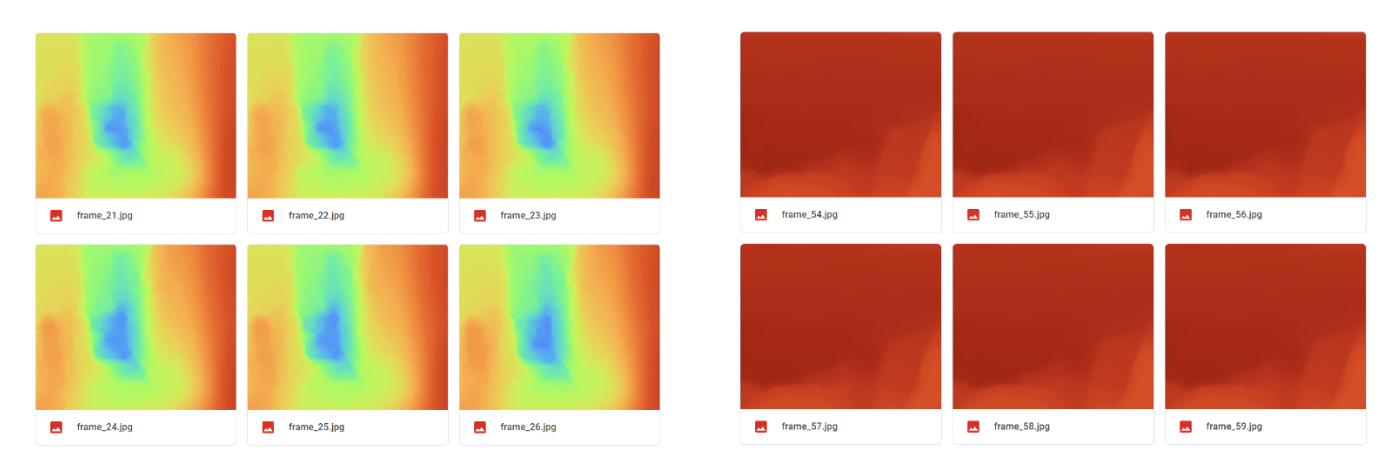

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
drive/  sample_data/


In [ ]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/LAIS')

There are 3657 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3657


### Create a dataset

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3657 files belonging to 2 classes.
Using 2926 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3657 files belonging to 2 classes.
Using 731 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['blocked', 'free']


### Visualize the data

Here are the first nine images from the training dataset:

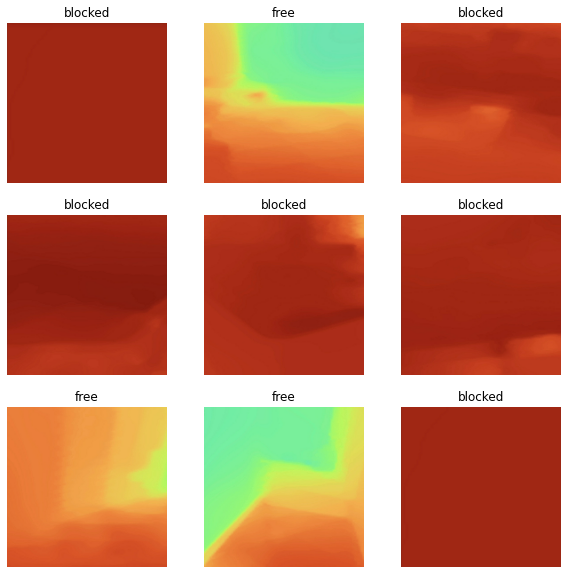

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#Update dataset performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardize the data

In [ ]:
#Aplying normalization
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

## Keras model


In [ ]:
num_classes = len(class_names)

#Standard Keras Model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 175s 392ms/step - loss: 0.0854 - accuracy: 0.9686 - val_loss: 0.0156 - val_accuracy: 0.9959
Epoch 2/10
92/92 [==============================] - 2s 23ms/step - loss: 0.0213 - accuracy: 0.9935 - val_loss: 0.0164 - val_accuracy: 0.9904
Epoch 3/10
92/92 [==============================] - 2s 23ms/step - loss: 0.0344 - accuracy: 0.9870 - val_loss: 0.0194 - val_accuracy: 0.9945
Epoch 4/10
92/92 [==============================] - 2s 23ms/step - loss: 0.0212 - accuracy: 0.9945 - val_loss: 0.0891 - val_accuracy: 0.9904
Epoch 5/10
92/92 [==============================] - 2s 23ms/step - loss: 0.0163 - accuracy: 0.9952 - val_loss: 0.0127 - val_accuracy: 0.9973
Epoch 6/10
92/92 [==============================] - 2s 25ms/step - loss: 0.0128 - accuracy: 0.9949 - val_loss: 0.0129 - val_accuracy: 0.9959
Epoch 7/10
92/92 [==============================] - 2s 27ms/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 0.0941 - val_accuracy: 0.9877
Epoch 8/10

## Visualizing training results

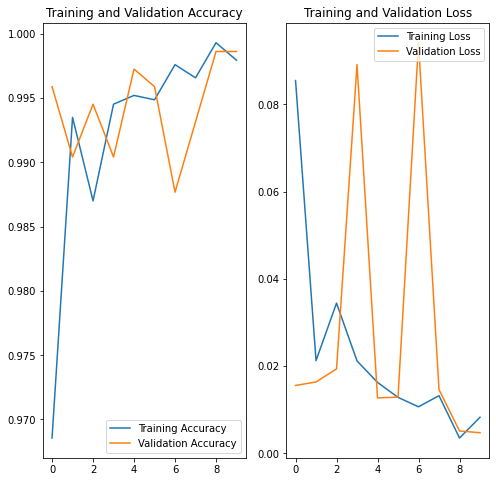

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()